# Serving model
## Learning Objectives
1. Learn how to export TensorFlow model in SavedModel format
2. Learn how to load SavedModel
3. Learn how to customize signature
4. Learn how to deploy models to Vertex AI
5. Learn how to use deployed model in online and batch prediction

In this lab, you will learn how to serve models after training. <br>

For serving, we need to set up the infrastructure, but by using Vertex AI service, which autoscale depending on demands, we can significantly reduce infrastructure setup and maintenance efforts.

To use Vertex AI, we will look at how to export a TensorFlow model in SavedModel format and deploy it into Vertex AI. Along the way, you learn about signatures, how to customize them, and how to get predictions out of a deployed model.

## Setup

In [1]:
import json
import os
import shutil
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from google.cloud import aiplatform

## Build and Train a Model
Model training is not a focus in this lab, so let's create a simple Mobilenet-based model and execute transfer learning quickly.

In [2]:
PROJECT = !(gcloud config get-value core/project)
PROJECT = PROJECT[0]
BUCKET = PROJECT + "-flowers"
FILE_DIR = f"gs://{BUCKET}/data"

CLASSES = ["daisy", "dandelion", "roses", "sunflowers", "tulips"]

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

BATCH_SIZE = 32

In [3]:
TRAIN_PATTERN = FILE_DIR + "/train*"
EVAL_PATTERN = FILE_DIR + "/eval*"


def parse_example(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, feature_description)
    example["image"] = tf.io.decode_jpeg(example["image"], channels=3)
    example["image"] = tf.image.resize(
        example["image"], [IMG_HEIGHT, IMG_WIDTH]
    )
    example["image"] = example["image"] / 255
    return example["image"], example["label"]


train_ds = (
    tf.data.TFRecordDataset(tf.io.gfile.glob(TRAIN_PATTERN))
    .map(parse_example)
    .batch(BATCH_SIZE)
)
eval_ds = (
    tf.data.TFRecordDataset(tf.io.gfile.glob(EVAL_PATTERN))
    .map(parse_example)
    .batch(10)
)

2022-07-04 19:50:25.822975: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 19:50:25.833575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 19:50:25.834191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 19:50:25.835754: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [4]:
module_selection = "mobilenet_v2_100_224"
module_handle = "https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(
    module_selection
)

transfer_model = tf.keras.Sequential(
    [
        hub.KerasLayer(module_handle, trainable=True),
        tf.keras.layers.Dropout(rate=0.2),
        tf.keras.layers.Dense(
            len(CLASSES),
            activation="softmax",
            kernel_regularizer=tf.keras.regularizers.l2(0.0001),
        ),
    ]
)

transfer_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

INFO:absl:Using /tmp/tfhub_modules to cache modules.


In [5]:
transfer_model.fit(
    train_ds,
    epochs=5,
    validation_data=eval_ds,
)

Epoch 1/5


2022-07-04 19:50:35.443553: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200


83/83 [==============================] - 33s 277ms/step - loss: 0.6631 - accuracy: 0.8028 - val_loss: 1.7826 - val_accuracy: 0.6824
Epoch 2/5
83/83 [==============================] - 20s 235ms/step - loss: 0.4184 - accuracy: 0.8868 - val_loss: 1.7535 - val_accuracy: 0.7675
Epoch 3/5
83/83 [==============================] - 19s 231ms/step - loss: 0.3359 - accuracy: 0.9114 - val_loss: 1.9147 - val_accuracy: 0.7416
Epoch 4/5
83/83 [==============================] - 19s 228ms/step - loss: 0.3257 - accuracy: 0.9251 - val_loss: 1.1155 - val_accuracy: 0.8070
Epoch 5/5
83/83 [==============================] - 19s 222ms/step - loss: 0.2839 - accuracy: 0.9300 - val_loss: 1.0372 - val_accuracy: 0.7827


## Export & load SavedModel
Now we have a trained model. In this section, we will export the model in SavedModel format.

Also, we will look at how to extend or model with an additional serving function that enables us to control the model's behavior by providing some preprocessing and postprocessing logic.

### Export in SavedModel 
A SavedModel contains a complete TensorFlow program, including trained parameters (i.e., tf.Variables) and computation. It does not require the original model building code to run, making it useful for sharing or deploying with TFLite, TensorFlow.js, TensorFlow Serving, or TensorFlow Hub.

You can save and load a model in the SavedModel format using the following APIs:

- Low-level [tf.saved_model](https://www.tensorflow.org/api_docs/python/tf/saved_model) API. This document describes how to use this API in detail.
  - Save: [tf.saved_model.save(model, path_to_dir)](https://www.tensorflow.org/api_docs/python/tf/saved_model/save)
  - Load: model = [tf.saved_model.load(path_to_dir)](https://www.tensorflow.org/api_docs/python/tf/saved_model/load)
- High-level [tf.keras.Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model?version=nightly) API. We recommend to use this API for Keras model since it output additional metadata related to Keras model. For detail refer to the [keras save and serialize guide](https://www.tensorflow.org/guide/keras/save_and_serialize).

If you just want to save/load weights during training, [Checkpoint](https://www.tensorflow.org/guide/checkpoint) would be sufficient.

Here let's try to export SavedModel with a high-level API.

In [6]:
shutil.rmtree("export", ignore_errors=True)
os.mkdir("export")
transfer_model.save("export/flowers_model")

2022-07-01 17:58:34.834168: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: export/flowers_model/assets
INFO:tensorflow:Assets written to: export/flowers_model/assets


Let's take a look at the directory.

In [7]:
!ls export/flowers_model

assets	keras_metadata.pb  saved_model.pb  variables


We can see multiple files in the directory.

- `saved_model.pb` is the SavedModel main file which contains the actual TensorFlow program, or model, and a set of named signatures, each identifying a function that accepts tensor inputs and produces tensor outputs.
- `keras_metadata.pb` file is created only with tf.keras.Model.save() function. It contains metadata regarding the Keras model.
- `variables` directory contains all the variables of the model.
- `assets` directory contains arbitrary files, called assets, that are needed for SavedModel. For example, a vocabulary file used to initialize a lookup table. Upon loading, the assets and the serialized functions that depend on them will refer to the correct file paths inside the SavedModel directory.


### Investigate a SavedModel with `saved_model_cli` command

If you installed TensorFlow through a pre-built TensorFlow binary, then the SavedModel CLI is already installed on your system at pathname `bin/saved_model_cli`.

The SavedModel CLI supports the following two commands on a SavedModel:

- `show`, which shows the computations available from a SavedModel.
- `run`, which runs a computation from a SavedModel.

Here let's investigate the SavedModel with `saved_model_cli show` command with `--dir` option to specify the file path.

In [8]:
!saved_model_cli show --dir export/flowers_model

The given SavedModel contains the following tag-sets:
'serve'


The command above was not specific enough to investigate a model graph. <br>
A SavedModel may contain multiple model variants identified by their tag-sets. But this is very rare.

Usually, we can simply specify a default tag-set name, `serve`.

In [9]:
!saved_model_cli show --dir export/flowers_model --tag_set serve

The given SavedModel MetaGraphDef contains SignatureDefs with the following keys:
SignatureDef key: "__saved_model_init_op"
SignatureDef key: "serving_default"


Still, it is not concrete enough. By adding a signature in the signature_def option, we can identify an actual function that we call.

By default, `serving_default` is the name of the serving function.

In [11]:
!saved_model_cli show --dir export/flowers_model --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['keras_layer_input'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 224, 224, 3)
      name: serving_default_keras_layer_input:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['dense'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 5)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


Now we can see the concrete function's descriptions.

- Its input shape is a batch(`-1`) of  224x224 images with 3 channels, named `'keras_layer_input'`.
- Its output shape is a batched 5 float values (that represent probabilities of 5 flowers), named `'dense'`

### load and predict

Once exported as SavedModel, we can load and use the model in a program.

If it is a Python program where the TensorFlow module is installed, you can just call `tf.saved_model.load(path)` for model loading.

Also, in the prediction phase, we sometimes (like in the Web API case) cannot expect that our model always receives preprocessed TFRecords data or batched `(224, 224, 3)` Tensors that we used in the training phase.<br>
let's say the model receives file paths to image data. Then we need to add preprocessing operations to handle the image paths before calling the model. 

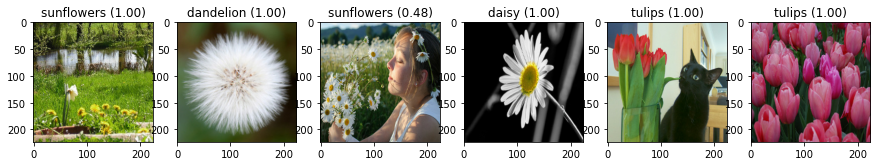

In [11]:
filenames = [
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9818247_e2eac18894.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/9853885425_4a82356f1d_m.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9158041313_7a6a102f7a_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/9299302012_958c70564c_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8733586143_3139db6e9e_n.jpg",
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713397358_0505cc0176_n.jpg",
]


def read_from_jpegfile(filename):
    # same code as in 05_create_dataset/jpeg_to_tfrecord.py
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

    return img


serving_model = tf.keras.models.load_model("export/flowers_model")
input_images = [read_from_jpegfile(f) for f in filenames]

f, ax = plt.subplots(1, 6, figsize=(15, 15))
for idx, img in enumerate(input_images):
    ax[idx].imshow(img.numpy())
    batch_image = tf.expand_dims(img, axis=0)
    batch_pred = transfer_model.predict(batch_image)
    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASSES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx].set_title(f"{pred_label} ({prob:.2f})")

### Additional Serving signature

So we need to write these additional codes all the time?<br>
The answer is no! By adding a custom serving signature, we can incorporate these additional preprocessing or postprocessing functions into the SavedModel itself.

Once compiled in a SavedModel, you can run the same logic in a different environment, including edge devices, C++ code, and Javascript programs.

Let's assume we deploy this model to a web server and provide prediction via a web API.

What kind of signature would be easiest for API clients to use? Instead of asking them to send us tensors of the image contents, we can simply ask them for a GCS JPEG file path, for example. <br>
And instead of returning a tensor of 5 probabilities, we can send back easy-to-understand information extracted from the probabilities.

Once we write a code, we can wrap the function with [`@tf.function()`](https://www.tensorflow.org/api_docs/python/tf/function?version=nightly) decorator.

By doing so, the tf.function-decorated methods are saved along with a SavedModel. However, any Python attributes, functions, and data are lost. This means that when a `tf.function` is exported, it saves a compiled graph, but not Python code itself.

Briefly, `tf.function` works by tracing the Python code to generate a `ConcreteFunction` (a callable wrapper around `tf.Graph`). When saving a `tf.function`, you're really saving the `tf.function`'s cache of ConcreteFunctions.


In [12]:
# fmt: off
# this function receives 1 string value.
@tf.function(input_signature=tf.TensorSpec([None,], dtype=tf.string)) 
def predict_flower_type(filenames):

    # custom preproces
    input_images = tf.map_fn(
        read_from_jpegfile, filenames, fn_output_signature=tf.float32
    )

    # model
    batch_pred = transfer_model(input_images)  # same as model.predict()

    # custom post-process
    top_prob = tf.math.reduce_max(batch_pred, axis=[1])
    pred_label_index = tf.math.argmax(batch_pred, axis=1)
    pred_label = tf.gather(tf.convert_to_tensor(CLASSES), pred_label_index)

    # custom output
    return {
        "probability": top_prob,
        "flower_type_int": pred_label_index,
        "flower_type_str": pred_label,
    }
# fmt: on

# Export model with a new serving function.
transfer_model.save(
    "export/flowers_model_2",
    signatures={"serving_default": predict_flower_type},
)

INFO:tensorflow:Assets written to: export/flowers_model_2/assets
INFO:tensorflow:Assets written to: export/flowers_model_2/assets


Let's take a look at the SavedModel description again.

In [13]:
!saved_model_cli show --dir export/flowers_model_2 --tag_set serve --signature_def serving_default

The given SavedModel SignatureDef contains the following input(s):
  inputs['filenames'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_filenames:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['flower_type_int'] tensor_info:
      dtype: DT_INT64
      shape: (-1)
      name: StatefulPartitionedCall:0
  outputs['flower_type_str'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: StatefulPartitionedCall:1
  outputs['probability'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1)
      name: StatefulPartitionedCall:2
Method name is: tensorflow/serving/predict


Now we can see our new SavedModel gets file paths and return dictionaries with three keys (`flower_type_int`, `flower_type_str`, and `probability`).

Let's try to load and use this SavedModel.<br>
Notice that now we don't need to write additional preprocessing or postprocessing codes.

In [14]:
serving_fn = tf.keras.models.load_model("export/flowers_model_2").signatures[
    "serving_default"
]

pred = serving_fn(tf.convert_to_tensor(filenames))

# print custom outputs
for k in pred.keys():
    print(f"{k:15}: {pred[k].numpy()}")

flower_type_int: [3 1 3 0 4 4]
flower_type_str: [b'sunflowers' b'dandelion' b'sunflowers' b'daisy' b'tulips' b'tulips']
probability    : [0.99952006 0.9999964  0.47697347 0.9999603  0.99999976 1.        ]


These outputs look more useful for API clients than a vector of probabilities.

## Vertex AI Prediction

Now our model is ready for deployment!

In this notebook, we deploy our model to the scalable Vertex AI service.
Vertex AI supports both Batch Prediction and Online Prediction. 

First, let's upload the SavedModel to Vertex AI.

### Upload model to Vertex AI Prediction service

In [15]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

REGION = "us-central1"
MODEL_DISPLAYNAME = f"flower_classifier-{TIMESTAMP}"

print(f"MODEL_DISPLAYNAME: {MODEL_DISPLAYNAME}")

# from https://cloud.google.com/vertex-ai/docs/predictions/pre-built-containers
SERVING_CONTAINER_IMAGE_URI = (
    "us-docker.pkg.dev/vertex-ai/prediction/tf2-gpu.2-8:latest"
)

MODEL_DISPLAYNAME: flower_classifier-20220701175910


We upload the SavedModel to a GCS bucket at first.

In [16]:
!gsutil cp -R export/flowers_model_2 gs://{BUCKET}/{MODEL_DISPLAYNAME}

Copying file://export/flowers_model_2/saved_model.pb [Content-Type=application/octet-stream]...
Copying file://export/flowers_model_2/keras_metadata.pb [Content-Type=application/octet-stream]...
Copying file://export/flowers_model_2/variables/variables.index [Content-Type=application/octet-stream]...
Copying file://export/flowers_model_2/variables/variables.data-00000-of-00001 [Content-Type=application/octet-stream]...
- [4 files][ 28.9 MiB/ 28.9 MiB]                                                
Operation completed over 4 objects/28.9 MiB.                                     


We can use Python SDK to upload models.

Here we are specifying `display_name`, `artifact_uri`, which is the path of SavedModel, and `serving_container_image_uri`, which is a container environment on which our model runs (pre-build container is selected in this case, but you can use a custom container if needed).

For more detail, please refer to [the SDK document](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_upload).

In [17]:
uploaded_model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAYNAME,
    artifact_uri=f"gs://{BUCKET}/{MODEL_DISPLAYNAME}",
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/849204435784/locations/us-central1/models/825016350878466048/operations/801802980356521984
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/849204435784/locations/us-central1/models/825016350878466048
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/849204435784/locations/us-central1/models/825016350878466048')


After uploading it, you can check your model on the console UI by clicking Vertex AI -> Models

### Batch Prediction

In batch prediction, we can pass a large dataset to our model and predict as a batch.<br>

#### Create a prediction file
[Batch Prediction](https://cloud.google.com/vertex-ai/docs/predictions/batch-predictions) service accepts JSON Lines, TF Records, CSV, or simple text file list format.

Here we create a simple dataset containing many image file paths in [JSON Lines](https://jsonlines.org/) format.

In [18]:
files = !gsutil ls -r gs://asl-public/data/flowers/jpegs/*.jpg
print(len(files))

442


In [19]:
JSON_FILE = "batch_prediction.jsonl"

with open(JSON_FILE, "w") as f:
    for file in files:
        f.write(json.dumps({"filenames": file}) + "\n")

!head {JSON_FILE}

{"filenames": "gs://asl-public/data/flowers/jpegs/10172567486_2748826a8b.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/10386503264_e05387e1f7_m.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/10391248763_1d16681106_n.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/10712722853_5632165b04.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/10778387133_9141024b10.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/112334842_3ecf7585dd.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/11233672494_d8bf0a3dbf_n.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/1140299375_3aa7024466.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/11595255065_d9550012fc.jpg"}
{"filenames": "gs://asl-public/data/flowers/jpegs/11694025703_9a906fedc1_n.jpg"}


In [20]:
!gsutil cp {JSON_FILE} {FILE_DIR}

Copying file://batch_prediction.jsonl [Content-Type=application/octet-stream]...
/ [1 files][ 34.3 KiB/ 34.3 KiB]                                                
Operation completed over 1 objects/34.3 KiB.                                     


#### Send a Batch Prediction Job
Let's call a batch prediction job with [`aiplatform.batch_predict()`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_batch_predict) function.

Note that we can specify machine type and accelerator as needed.<br>
This is very useful when we want to process a large amount of data in a limited time.

In [21]:
TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

JOB_DISPLAY_NAME = "flower_classification_batch"
MACHINE_TYPE = "n1-standard-4"

batch_pred_job = uploaded_model.batch_predict(
    job_display_name=JOB_DISPLAY_NAME,
    gcs_source=f"{FILE_DIR}/{JSON_FILE}",
    gcs_destination_prefix=f"{FILE_DIR}/batch_prediction_result/{TIMESTAMP}",
    machine_type=MACHINE_TYPE,
    accelerator_type="NVIDIA_TESLA_T4",
    accelerator_count=1,
    sync=False,
)

INFO:google.cloud.aiplatform.jobs:Creating BatchPredictionJob
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob created. Resource name: projects/849204435784/locations/us-central1/batchPredictionJobs/442879160499568640
INFO:google.cloud.aiplatform.jobs:To use this BatchPredictionJob in another session:
INFO:google.cloud.aiplatform.jobs:bpj = aiplatform.BatchPredictionJob('projects/849204435784/locations/us-central1/batchPredictionJobs/442879160499568640')
INFO:google.cloud.aiplatform.jobs:View Batch Prediction Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/batch-predictions/442879160499568640?project=849204435784
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/849204435784/locations/us-central1/batchPredictionJobs/442879160499568640 current state:
JobState.JOB_STATE_RUNNING
INFO:google.cloud.aiplatform.jobs:BatchPredictionJob projects/849204435784/locations/us-central1/batchPredictionJobs/442879160499568640 current state:
JobState.JOB_STATE_RUN

**Notice it takes around 20 minutes. Please wait until that or move forward to the Online Prediction section and return to the next cell later. You can check the status on Vertex AI -> Batch Predictions page**

In [23]:
if batch_pred_job.output_info:
    output_dir = batch_pred_job.output_info.gcs_output_directory
    results = !gsutil cat {output_dir}/prediction.results*
    for r in results[:5]:
        r = json.loads(r)
        print(f"filename       : {r['instance']['filenames']}")
        for k in r["prediction"].keys():
            print(f"{k:15}: {r['prediction'][k]}")
        print("*" * 30)
else:
    print(f"This job is still running.")

filename       : gs://asl-public/data/flowers/jpegs/10172567486_2748826a8b.jpg
flower_type_str: daisy
probability    : 0.989581227
flower_type_int: 0
******************************
filename       : gs://asl-public/data/flowers/jpegs/10386503264_e05387e1f7_m.jpg
flower_type_str: sunflowers
probability    : 0.999999642
flower_type_int: 3
******************************
filename       : gs://asl-public/data/flowers/jpegs/10391248763_1d16681106_n.jpg
flower_type_str: dandelion
probability    : 0.499147207
flower_type_int: 1
******************************
filename       : gs://asl-public/data/flowers/jpegs/10712722853_5632165b04.jpg
flower_type_str: daisy
probability    : 0.999851465
flower_type_int: 0
******************************
filename       : gs://asl-public/data/flowers/jpegs/10778387133_9141024b10.jpg
flower_type_str: sunflowers
probability    : 0.785376132
flower_type_int: 3
******************************


### Online Prediction

In the Online Prediction option, you can create a dedicated endpoint for your model, and use it as a web API.

Let's create an endpoint and link your model to it by [`aiplatform.Model.deploy`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Model#google_cloud_aiplatform_Model_deploy) function. Here you can also specify the machine type and the accelerators.

**The command below takes around 10 minutes.**

In [25]:
endpoint = uploaded_model.deploy(
    machine_type=MACHINE_TYPE,
    accelerator_type="NVIDIA_TESLA_T4",
    accelerator_count=1,
)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/849204435784/locations/us-central1/endpoints/5022454766471479296/operations/6413851066013581312
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/849204435784/locations/us-central1/endpoints/5022454766471479296
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/849204435784/locations/us-central1/endpoints/5022454766471479296')
INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/849204435784/locations/us-central1/endpoints/5022454766471479296
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/849204435784/locations/us-central1/endpoints/5022454766471479296/operations/8553060889014566912
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/84920443578

After the deployment, we can simply call the endpoint and retrieve the result. <br>
You can check the endpoint details by visiting the Vertex AI -> Endpoints page.

Here we stick with the [Python SDK](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.Endpoint#google_cloud_aiplatform_Endpoint_predict), but note that you can call the endpoint from any environment.

In [26]:
instances = [{"filenames": f} for f in filenames]

In [27]:
pred = endpoint.predict(instances=instances)

# print custom outputs
for p in pred.predictions:
    for k in p.keys():
        print(f"{k:15}: {p[k]}")
    print("*" * 30)

flower_type_str: sunflowers
probability    : 0.999520063
flower_type_int: 3.0
******************************
flower_type_str: dandelion
probability    : 0.999996424
flower_type_int: 1.0
******************************
probability    : 0.476973414
flower_type_int: 3.0
flower_type_str: sunflowers
******************************
flower_type_int: 0.0
flower_type_str: daisy
probability    : 0.999960303
******************************
flower_type_str: tulips
flower_type_int: 4.0
probability    : 0.999999762
******************************
probability    : 1.0
flower_type_int: 4.0
flower_type_str: tulips
******************************


## Summary
We learned how to:
- export and load a SavedModel
- customize the serving function to control a SavedModel behavior
- deploy a SavedModel to Vertex AI
- Use deployed model both for Batch and Online predictions.


Copyright 2022 Google Inc.
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.